In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

In [2]:
data = pd.read_csv('WA_statewide_metrics_concise.csv')
data.head(10)

,Unnamed: 0,schoolyear,OrganizationLevel,StudentGroupType,StudentGroup,Domain,Measure,MeasureValue,Numerator,Denominator,Percent,DevelopmentLevel,Suppress,DataAsOf
0,10845,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,NaN,506.0,6661.0,0.07596,NaN,NaN,NaN
1,11175,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,N,1377.0,6661.0,0.20673,NaN,NaN,NaN
2,11354,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,Y,4778.0,6661.0,0.71731,NaN,NaN,NaN
3,37984,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,0-2 year olds,16.0,5902.0,0.00271,NaN,NaN,NaN
4,38010,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,2-year olds,157.0,5902.0,0.02660,NaN,NaN,NaN
5,38063,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,3-year olds,468.0,5902.0,0.07930,NaN,NaN,NaN
6,38223,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,4-year olds,2503.0,5902.0,0.42409,NaN,NaN,NaN
7,38484,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,Kindergarten and up,2758.0,5902.0,0.46730,NaN,NaN,NaN
8,38563,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,NaN,759.0,6661.0,0.11395,NaN,NaN,NaN
9,39027,2011-12,State,All,All Students,Literacy,LiteracyReadinessFlag,N,1639.0,6661.0,0.24606,NaN,NaN,NaN


In [3]:
# finding the unique values for each col
print(f'SchoolYear: {data["schoolyear"].unique()}')
print(f'OrganizationLevel: {data["OrganizationLevel"].unique()}')
print(f'StudentGroupType: {data["StudentGroup"].unique()}')
print(f'StudentGroup: {data["StudentGroup"].unique()}')
print(f'Domain: {data["Domain"].unique()}')
print(f'Measure: {data["Measure"].unique()}')
print(f'MeasureValue: {data["MeasureValue"].unique()}')

SchoolYear: ['2011-12' '2012-13' '2013-14' '2014-15' '2015-16' '2016-17' '2017-18'
 '2018-19' '2019-20' '2021-22' '2022-23' '2023-24']
OrganizationLevel: ['State']
StudentGroupType: ['All Students' 'American Indian/ Alaskan Native'
 'Black/ African American' 'Hispanic/ Latino of any race(s)' 'White'
 'Asian' 'Native Hawaiian/ Other Pacific Islander' 'TwoorMoreRaces']
StudentGroup: ['All Students' 'American Indian/ Alaskan Native'
 'Black/ African American' 'Hispanic/ Latino of any race(s)' 'White'
 'Asian' 'Native Hawaiian/ Other Pacific Islander' 'TwoorMoreRaces']
Domain: ['Cognitive' 'Literacy' 'Math' 'SocialEmotional']
Measure: ['CognitiveReadinessFlag' 'LiteracyDevelopmentLevel'
 'LiteracyReadinessFlag' 'MathDevelopmentLevel' 'MathReadinessFlag'
 'SocialEmotionalDevelopmentLevel' 'SocialEmotionalReadinessFlag'
 'CognitiveDevelopmentLevel']
MeasureValue: [nan 'N' 'Y' '0-2 year olds' '2-year olds' '3-year olds' '4-year olds'
 'Kindergarten and up' 'Blue' 'Green' 'orange' 'purple' 'Ye

In [4]:
# create a numerical year column (num_year represents the number of years it has been since 2011)
#years = all_students_data['schoolyear'].unique()
def year_numerizer(yr):
    if (yr == '2011-12'):
        return 0
    elif (yr == '2012-13'):
        return 1
    elif (yr == '2013-14'):
        return 2
    elif (yr == '2014-15'):
        return 3
    elif (yr == '2015-16'):
        return 4
    elif (yr == '2016-17'):
        return 5
    elif (yr == '2017-18'):
        return 6
    elif (yr == '2018-19'):
        return 7
    elif (yr == '2019-20'):
        return 8
    elif (yr == '2020-21'):
        return 9
    elif (yr == '2021-22'):
        return 10
    elif (yr == '2022-23'):
        return 11
    else:
        return 12

data['num_year'] = data['schoolyear'].apply(year_numerizer)

# create a numerical level column (used for the level analysis)
def level_numerizer(level):
    if (level == '0-2 year olds') | (level == 'orange'):
        return 1
    elif (level == '2-year olds') | (level == 'Yellow'):
        return 2
    elif (level == '3-year olds') | (level == 'Green'):
        return 3
    elif (level == '4-year olds') | (level == 'Blue'):
        return 4
    elif (level == 'Kindergarten and up') | (level == 'purple'):
        return 5
    else:
        return np.nan

data['Readiness'] = data['MeasureValue'].apply(level_numerizer)

# drop rows where the MeasureValue is na
data = data[~data['MeasureValue'].isna()]

In [5]:
# remove spaces from column names
data.columns = data.columns.str.replace(' ', '')
data.columns = data.columns.str.replace('(', '')
data.columns = data.columns.str.replace(')', '')
data.columns = data.columns.str.replace('/', '')

### Only looking at All Students

In [6]:
# get data only for all students
all_students_data = data[data['StudentGroupType'] == 'All']
all_students_data.head()

,Unnamed:0,schoolyear,OrganizationLevel,StudentGroupType,StudentGroup,Domain,Measure,MeasureValue,Numerator,Denominator,Percent,DevelopmentLevel,Suppress,DataAsOf,num_year,Readiness
1,11175,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,N,1377.0,6661.0,0.20673,NaN,NaN,NaN,0,NaN
2,11354,2011-12,State,All,All Students,Cognitive,CognitiveReadinessFlag,Y,4778.0,6661.0,0.71731,NaN,NaN,NaN,0,NaN
3,37984,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,0-2 year olds,16.0,5902.0,0.00271,NaN,NaN,NaN,0,1.0
4,38010,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,2-year olds,157.0,5902.0,0.02660,NaN,NaN,NaN,0,2.0
5,38063,2011-12,State,All,All Students,Literacy,LiteracyDevelopmentLevel,3-year olds,468.0,5902.0,0.07930,NaN,NaN,NaN,0,3.0


In [7]:
# get data for all students, only using flag measures
flags = ['CognitiveReadinessFlag', 'LiteracyReadinessFlag', 'MathReadinessFlag', 'SocialEmotionalReadinessFlag']
all_students_flag = all_students_data[all_students_data['Measure'].isin(flags)]
all_students_flag = all_students_flag.dropna(subset = ['MeasureValue'])

# get data for all students, only using level measures
levels = ['CognitiveDevelopmentLevel', 'LiteracyDevelopmentLevel', 'MathDevelopmentLevel', 'SocialEmotionalDevelopmentLevel']
all_students_level = all_students_data[all_students_data['Measure'].isin(levels)]

**Analysis for "Flag" measures**

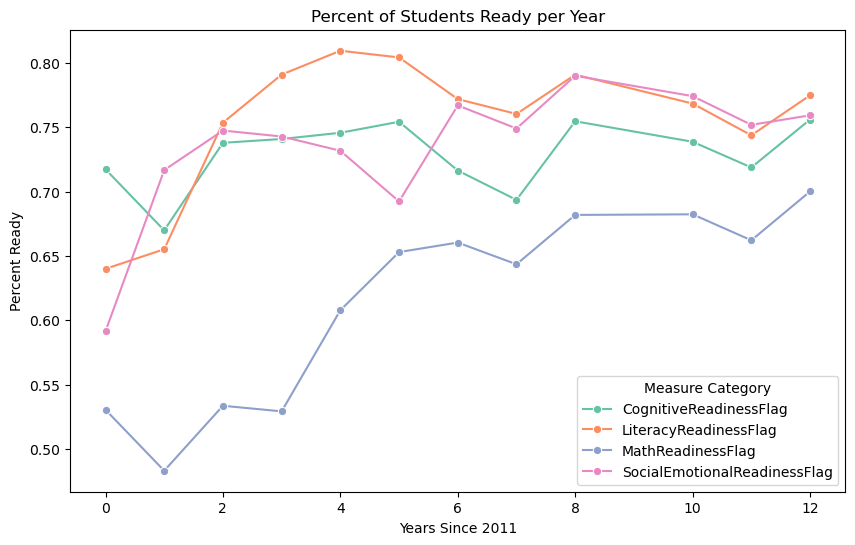

In [8]:
# only look at the 'Y' MeasureValue
plt.figure(figsize = (10, 6))
sns.lineplot(data = all_students_flag[all_students_flag['MeasureValue'] == 'Y'], x = 'num_year', y = 'Percent', hue = 'Measure', palette = 'Set2', marker = 'o')
plt.title("Percent of Students Ready per Year")
plt.xlabel("Years Since 2011")
plt.ylabel("Percent Ready")
plt.legend(title = "Measure Category")

**Analysis for "Level" measures**

/Users/meganpratt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Cognitive Development Level')

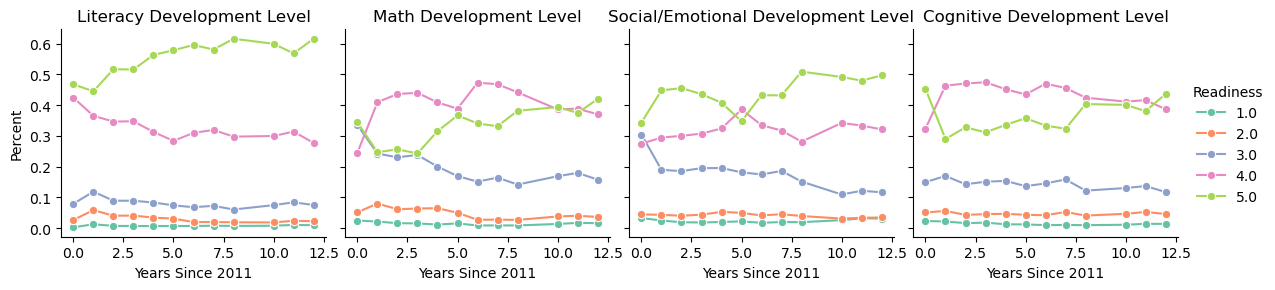

In [9]:
g = sns.FacetGrid(all_students_level, col = 'Measure', hue = 'Readiness', palette = 'Set2')
g.map(sns.lineplot, 'num_year', 'Percent', marker = 'o')
g.add_legend()

g.axes[0, 0].set_xlabel('Years Since 2011')
g.axes[0, 0].set_title('Literacy Development Level')

g.axes[0, 1].set_xlabel('Years Since 2011')
g.axes[0, 1].set_title('Math Development Level')

g.axes[0, 2].set_xlabel('Years Since 2011')
g.axes[0, 2].set_title('Social/Emotional Development Level')

g.axes[0, 3].set_xlabel('Years Since 2011')
g.axes[0, 3].set_title('Cognitive Development Level')

### Comparing other demographics to the average "All Students"

In [10]:
# datasets for just the flags and just the levels
data_flag = data[data['Measure'].isin(flags)]
data_flag = data_flag[data_flag['MeasureValue'] == 'Y']
data_level = data[data['Measure'].isin(levels)]

/Users/meganpratt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Social/Emotional Readiness')

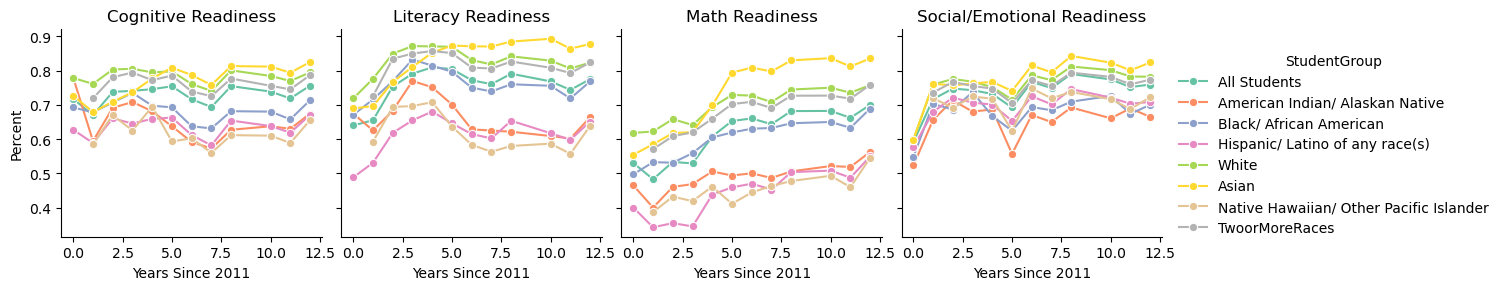

In [11]:
g = sns.FacetGrid(data_flag, col = 'Measure', hue = 'StudentGroup', palette = 'Set2')
g.map(sns.lineplot, 'num_year', 'Percent', marker = 'o')
g.add_legend()

#
g.axes[0, 0].set_xlabel('Years Since 2011')
g.axes[0, 0].set_title('Cognitive Readiness')

g.axes[0, 1].set_xlabel('Years Since 2011')
g.axes[0, 1].set_title('Literacy Readiness')

g.axes[0, 2].set_xlabel('Years Since 2011')
g.axes[0, 2].set_title('Math Readiness')

g.axes[0, 3].set_xlabel('Years Since 2011')
g.axes[0, 3].set_title('Social/Emotional Readiness')

### ANOVA Test

test if each readiness flag is the same among all student groups.

In [12]:
# testing if adding num_year impacts the regression
not_all_students_flag = data_flag[data_flag['StudentGroup'] != 'All Students']
small_model_flag = smf.ols('Percent ~ C(StudentGroup)', data = not_all_students_flag).fit()
small_model_flag.summary()

big_model_flag = smf.ols('Percent ~ C(StudentGroup) + num_year', data = not_all_students_flag).fit()
big_model_flag.summary()


sm.stats.anova_lm(small_model_flag, big_model_flag)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,321.0,2.268132,0.0,NaN,NaN,NaN
1,320.0,2.126106,1.0,0.142026,21.376345,0.000005


**Residual Diagnostics**

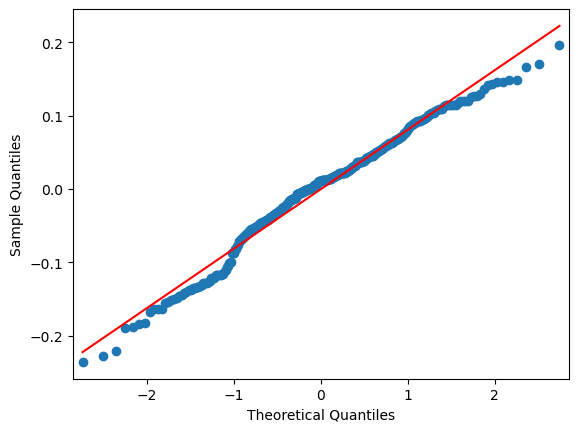

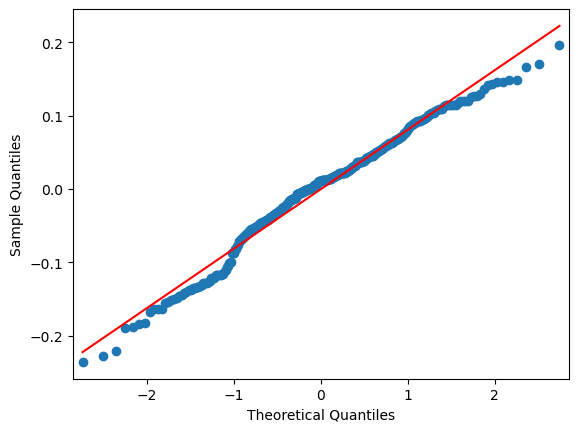

In [13]:
# normality
sm.qqplot(big_model_flag.resid, line = 'r')

<BarContainer object of 21 artists>

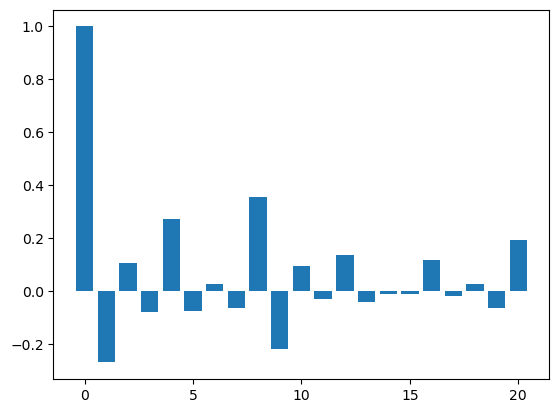

In [14]:
# independence
lags = 20
plt.bar(range(lags + 1), acf(big_model_flag.resid, nlags = lags))

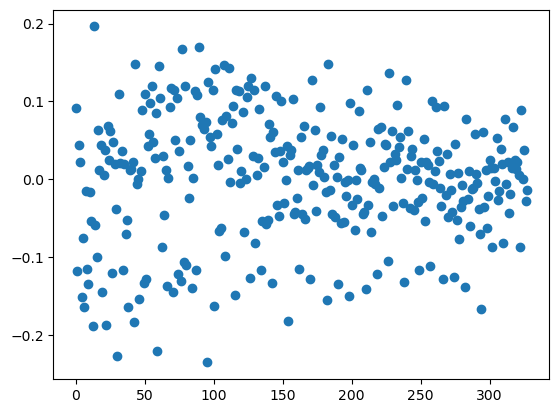

In [15]:
# heteroscedasticity
def standardize(x):
    return (x - x.mean()) / x.std()

plt.scatter(range(not_all_students_flag.shape[0]), big_model_flag.resid)